In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

ds = fetch_openml ('mnist_784', as_frame = False )

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
df = pd.DataFrame({'Images':list(ds.data), 'Target': ds.target})

In [3]:
import cv2
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

In [4]:
train_idx = []
val_idx = []
for category in df.Target.unique():
    train_idx += df[df.Target==category].sample(100).index.to_list()
    val_idx += df[((~(df.index.isin(train_idx)))&(df.Target==category))].sample(100).index.to_list()
train_df = df[df.index.isin(train_idx)]
val_df = df[df.index.isin(val_idx)]
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
print(train_df.shape, val_df.shape)
train_df.Target.value_counts(), val_df.Target.value_counts()

(1000, 2) (1000, 2)


(4    100
 8    100
 1    100
 9    100
 6    100
 3    100
 2    100
 7    100
 5    100
 0    100
 Name: Target, dtype: int64,
 8    100
 6    100
 5    100
 3    100
 2    100
 9    100
 7    100
 4    100
 0    100
 1    100
 Name: Target, dtype: int64)

In [5]:
train_df['Final_Img'] = train_df.Images.apply(lambda x: cv2.resize(x.reshape((28,28)),(14,14)).flatten())
val_df['Final_Img'] = val_df.Images.apply(lambda x: cv2.resize(x.reshape((28,28)),(14,14)).flatten())
x = np.stack(train_df.Final_Img)
y = train_df.Target
x_test = np.stack(val_df.Final_Img)
y_test = val_df.Target
train_df.shape, x.shape, y.shape, val_df.shape, x_test.shape, y_test.shape

<ipython-input-5-7d56a3136100>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Final_Img'] = train_df.Images.apply(lambda x: cv2.resize(x.reshape((28,28)),(14,14)).flatten())
<ipython-input-5-7d56a3136100>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['Final_Img'] = val_df.Images.apply(lambda x: cv2.resize(x.reshape((28,28)),(14,14)).flatten())


((1000, 3), (1000, 196), (1000,), (1000, 3), (1000, 196), (1000,))

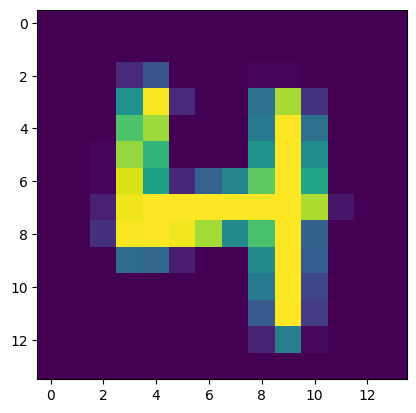

In [6]:
plt.imshow(x[0].reshape((14,14)))

In [7]:
del train_df
del val_df
del train_idx
del val_idx

In [8]:
from skimage.filters import gabor_kernel, gabor

In [9]:
image = x[0].reshape((14,14))
image.shape

(14, 14)

In [10]:
freq, theta, bandwidth = 0.05, 0, 0.3
gk = gabor_kernel(frequency = freq, theta = theta, bandwidth = bandwidth)
coeff_real, _ = gabor(image, frequency=freq, theta = theta,
                      bandwidth = bandwidth)
coeff_real.shape

(14, 14)

In [11]:
theta = np.arange(0, np.pi, np.pi/4)
frequency = np.arange(0.05, 0.5, 0.15)
bandwidth = np.arange(0.3, 1, 0.3)
theta, frequency, bandwidth

(array([0.        , 0.78539816, 1.57079633, 2.35619449]),
 array([0.05, 0.2 , 0.35]),
 array([0.3, 0.6, 0.9]))

In [12]:
196*36+196

7252

In [13]:
np.save('x_train.npy', x)
np.save('y_train.npy', y)
np.save('x_test.npy', x_test)
np.save('y_test.npy', y_test)

In [21]:
%%time
x_gabor = []
x_test_gabor = []
count=0
for i in range(x.shape[0]):
    count += 1
    input = []
    t_input = []
    image = x[i].reshape((14,14))
    t_image = x_test[i].reshape((14,14))
    for t in theta:
        for f in frequency:
            for b in bandwidth:
                # print(t,f,b)
                gk = gabor_kernel(frequency = f, theta = t, bandwidth = b)
                coeff_real, _ = gabor(image, frequency=f, theta = t,
                      bandwidth = b)
                input += [coeff_real.reshape((196))]

                t_coeff_real, _ = gabor(t_image, frequency=f, theta = t,
                      bandwidth = b)
                t_input += [t_coeff_real.reshape((196))]
    x_gabor += [input]
    x_test_gabor += [t_input]

    if count%100 == 0:
      print(count)


100
200
300
400
500
600
700
800
900
1000
CPU times: user 1h 35min 21s, sys: 7min 42s, total: 1h 43min 4s
Wall time: 1h 43min 16s


In [22]:
x_gabor = np.array(x_gabor).reshape((x.shape[0], -1))
x_test_gabor = np.array(x_test_gabor).reshape((x.shape[0], -1))
x_gabor.shape, x_test_gabor.shape

((1000, 7056), (1000, 7056))

In [23]:
x_test_gabor[0,:]

array([-0.0320522 , -0.02901002, -0.02070705, ...,  0.26600616,
       -0.42739144, -0.26240871])

In [24]:
x_gabor[0,:]

array([-3.72893474e-02, -2.20773216e-02, -3.79125342e-03, ...,
        4.26717715e+00, -7.17931903e-01, -7.48719786e-01])

In [25]:
np.save('Gabor_train_x_samples.npy', x_gabor)
np.save('Gabor_train_y_samples.npy', y)
np.save('Gabor_test_x_samples.npy', x_test_gabor)
np.save('Gabor_test_y_samples.npy', y_test)

In [26]:
### try scaling the input
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(x_gabor)
X_test = scaler.transform(x_test_gabor)
X.shape, X_test.shape

((1000, 7056), (1000, 7056))

In [27]:
print(X.shape, X[827][:10])
print(X_test.shape, X_test[827][:10])

(1000, 7056) [-0.33041446 -0.57216865 -0.92958287 -0.27347249  0.0839441   0.07694404
  0.24440795  0.60377212  0.17981851 -0.09267731]
(1000, 7056) [-1.21646746 -1.39156933 -1.42938191 -1.28138961 -0.44126882  0.30821698
  1.04946994  1.33714799  1.31225484  1.19979982]


In [28]:
print(X.shape, X[0][:10])
print(X_test.shape, X_test[0][:10])

(1000, 7056) [-0.35562012  0.5167303   1.41600316  1.28913036  0.6189284  -0.01393248
 -0.52657766 -0.04955422  0.45615573  0.8244076 ]
(1000, 7056) [ 0.11595467 -0.16807763 -0.60930352 -1.06784412 -1.03535447 -1.03677068
 -0.76007446 -0.36374823 -0.35139719 -0.35546763]


In [29]:
parameters = {'kernel':['linear', 'rbf'],
              'C':[0.25, 0.5, 0.75, 1, 10],
              'gamma': ['scale', 'auto']}
svc = SVC()
clf_gs = GridSearchCV(svc, parameters)
clf_gs.fit(X, y)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.25, 0.5, 0.75, 1, 10],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']})

In [30]:
pd.DataFrame(clf_gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.869475,0.041860,0.396456,0.023379,0.25,scale,linear,"{'C': 0.25, 'gamma': 'scale', 'kernel': 'linear'}",0.835,0.845,0.860,0.855,0.860,0.851,0.009695,9
1,2.545533,0.123344,1.301127,0.049606,0.25,scale,rbf,"{'C': 0.25, 'gamma': 'scale', 'kernel': 'rbf'}",0.805,0.825,0.855,0.865,0.855,0.841,0.022450,19
2,0.831881,0.012040,0.416295,0.017761,0.25,auto,linear,"{'C': 0.25, 'gamma': 'auto', 'kernel': 'linear'}",0.835,0.845,0.860,0.855,0.860,0.851,0.009695,9
3,2.516485,0.118239,1.319110,0.070142,0.25,auto,rbf,"{'C': 0.25, 'gamma': 'auto', 'kernel': 'rbf'}",0.805,0.825,0.855,0.865,0.855,0.841,0.022450,19
4,0.865657,0.012682,0.431511,0.018432,0.5,scale,linear,"{'C': 0.5, 'gamma': 'scale', 'kernel': 'linear'}",0.835,0.845,0.860,0.855,0.860,0.851,0.009695,9
5,2.151021,0.061734,1.272342,0.093025,0.5,scale,rbf,"{'C': 0.5, 'gamma': 'scale', 'kernel': 'rbf'}",0.870,0.885,0.895,0.900,0.885,0.887,0.010296,7
6,0.835679,0.013421,0.407554,0.028765,0.5,auto,linear,"{'C': 0.5, 'gamma': 'auto', 'kernel': 'linear'}",0.835,0.845,0.860,0.855,0.860,0.851,0.009695,9
7,2.066118,0.048754,1.207497,0.066405,0.5,auto,rbf,"{'C': 0.5, 'gamma': 'auto', 'kernel': 'rbf'}",0.870,0.885,0.895,0.900,0.885,0.887,0.010296,7
8,0.897841,0.046047,0.438129,0.022378,0.75,scale,linear,"{'C': 0.75, 'gamma': 'scale', 'kernel': 'linear'}",0.835,0.845,0.860,0.855,0.860,0.851,0.009695,9
9,1.994023,0.082243,1.158604,0.039404,0.75,scale,rbf,"{'C': 0.75, 'gamma': 'scale', 'kernel': 'rbf'}",0.890,0.885,0.925,0.925,0.885,0.902,0.018868,5


In [31]:
clf_gs.best_score_, clf_gs.best_params_

(0.905, {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'})

In [36]:
clf = SVC(gamma='scale', C=10, kernel = 'rbf')
clf.fit(X, y)

SVC(C=10)

In [38]:
clf.score(X, y)

1.0

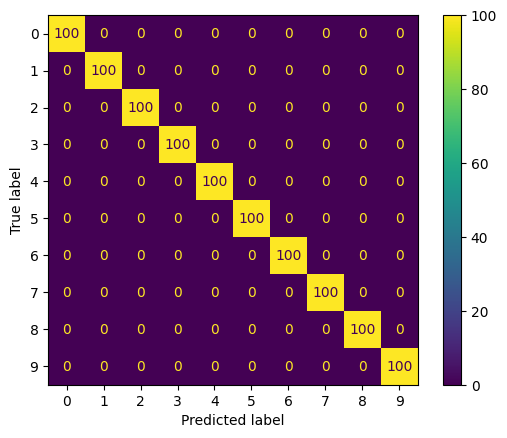

In [42]:
y_train_pred = clf.predict(X)
cm = confusion_matrix(y, y_train_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=clf.classes_)
disp.plot()
plt.show()

In [40]:
clf.score(X_test, y_test)

0.905

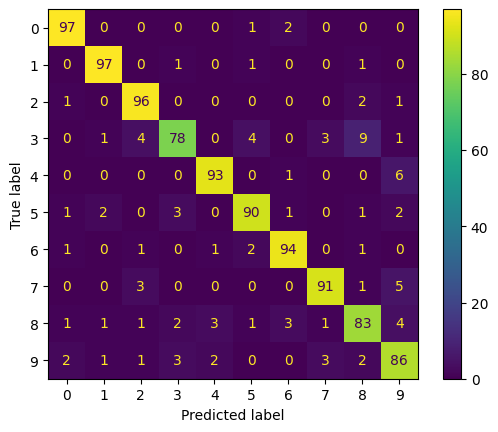

In [43]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=clf.classes_)
disp.plot()
plt.show()